IMPORTING IMPORTANT MODULES

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import time
from tensorflow.keras.models import  Sequential, load_model

DOWNLOADING DATASET FROM KAGGLE

In [2]:
#way to download kaggle dataset in google drive
#config
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/gan_" #path to where kaggle.json is located
#download dataset
!kaggle datasets download -d soumikrakshit/anime-faces

 98% 432M/441M [00:04<00:00, 89.9MB/s]
100% 441M/441M [00:04<00:00, 95.7MB/s]


In [3]:
from zipfile import ZipFile
with ZipFile("anime-faces.zip", "r") as zipobj:
    zipobj.extractall("./")

LOADING DATASET

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data/data", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 21551 files belonging to 1 classes.


(32, 64, 64, 3)


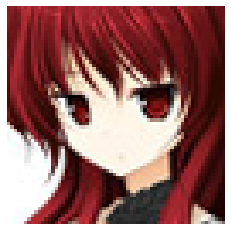

In [5]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    print(x.shape)
    break

MODEL CREATION

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*128, use_bias=False, input_shape=(128,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Reshape((8, 8, 128)))
    assert model.output_shape == (None, 8, 8, 128)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(256, (4,4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(512, (4,4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(3, (5,5), padding='same', activation='sigmoid'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4,4), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (4,4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (4,4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))

    return model

MODEL INITIALIZATION

In [7]:
#create generator modal
#generator = make_generator_model()
generator = load_model('/content/drive/MyDrive/Colab Notebooks/gan_/generator_anime.h5')
#create discriminator modal
#discriminator = make_discriminator_model()
discriminator = load_model('/content/drive/MyDrive/Colab Notebooks/gan_/discriminator_anime.h5')

LOSS FUNCTIONS

In [8]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

OPTIMIZERS

In [9]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

SEED VALUE TO USE IT AGAIN AND AGAIN WITH GENERATORS

In [10]:
EPOCHS = 50
BATCH_SIZE = 32
noise_dim = 128
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

TRAINING FUNCTION

In [11]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss)

CODE TO SAVE IMAGES IN EACH EPOCHS

In [12]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(7, 7))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i].numpy() * 255).astype("int32"))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

TRAINING....

In [13]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      loss = train_step(image_batch)

    # Produce images for the GIF as you go
    #display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    # checkpoint.save(file_prefix = checkpoint_prefix)

    print(f'Time for epoch {epoch + 1} is {time.time()-start} sec>>> GEN_LOSS = {loss[0]} DISC_LOSS = {loss[1]}')

In [ ]:
train(dataset, epochs=50)

Output hidden; open in https://colab.research.google.com to view.

SAVING MODELS....

In [ ]:
generator.save('/content/drive/MyDrive/Colab Notebooks/gan_/generator_anime.h5')
discriminator.save('/content/drive/MyDrive/Colab Notebooks/gan_/discriminator_anime.h5')

VISUALIZING THE GENERATED IMAGES PER EPOCHS

In [ ]:
import glob
import imageio

anim_file = '/content/drive/MyDrive/Colab Notebooks/gan_/dcgan_anime.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
from IPython.display import Image
Image(open(anim_file,'rb').read())

Output hidden; open in https://colab.research.google.com to view.

CHANGING FPS TO VISUALIZE MORE BETTER

In [ ]:
gif = imageio.mimread(anim_file)
speed_up_gif = '/content/drive/MyDrive/Colab Notebooks/gan_/dcgan_anime_fps.gif'
imageio.mimsave(speed_up_gif, gif, fps=1)

In [ ]:
from IPython.display import Image
Image(open(speed_up_gif,'rb').read())

Output hidden; open in https://colab.research.google.com to view.

CREATING RANDOM FACES WITH RANDOM LATENT SPACE

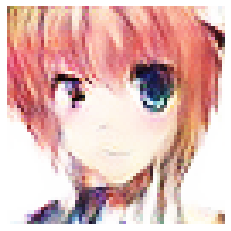

In [139]:
plt.imshow((generator(tf.random.normal([1, noise_dim]), training=False)[0].numpy()*255).astype("int32"))
plt.axis('off')
plt.show()